In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from PIL import Image, ImageFont, ImageDraw

%matplotlib inline

In [3]:
_ = np.seterr(divide='ignore', invalid='ignore')

In [4]:
def display_pillow_image(image: Image):
    bio = io.BytesIO()
    image.save(bio, format='png')
    ipd.display(ipd.Image(bio.getvalue(), format='png'))
    

def display_ndarray_image(image: np.ndarray) -> None:
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap="binary")
    plt.show()

In [5]:
FONT_PATH = "data/fonts/kirillica-nova-unicode.ttf"
ALPHABET = [
    "\u0430",
    "\u0431",
    "\u0432",
    "\u0433",
    "\u0434",
    "\u0454",
    "\u0436",
    "\u0455",
    "\u0437",
    "\u0438",
    "\u0456",
    "\u045B",
    "\u043A",
    "\u043B",
    "\u043C",
    "\u043D",
    "\u043E",
    "\u043F",
    "\u0440",
    "\u0441",
    "\u0442",
    "\u0479",
    "\u0444",
    "\u0445",
    "\u0461",
    "\u047F",
    "\u0446",
    "\u0447",
    "\u0481",
    "\u0448",
    "\u0449",
    "\u044A",
    "\u044B",
    "\u044C",
    "\u0463",
    "\u044E",
    "\u0465",
    "\u0467",
    "\u046B",
    "\u046D",
    "\u046F",
    "\u0471",
    "\u0473",
    "\u0475",
]

In [6]:
def otsu_threshold(image):
    image = image.flatten()
    hist = np.bincount(image, minlength=256)  # (256,)
    nonzero = hist.nonzero()[0]  # (N,)
    hist = hist[nonzero] / len(image)  # (N,)
    
    w_0 = hist.cumsum()  # (N,)
    w_1 = 1 - w_0  # (N,)
    
    cumsum = (nonzero * hist).cumsum()  # (N,)
    M_0 = cumsum / w_0  # (N,)
    M_1 = (cumsum[-1] - cumsum) / w_1  # (N,)
    
    grid = nonzero[None].repeat(len(nonzero), axis=0)  # (N, N)
        
    D_0 = grid - M_0[:, None]  # (N, N)
    D_0 = D_0**2 * hist  # (N, N)
    D_0 = np.tril(D_0).sum(1)  # (N,)
    
    D_1 = grid - M_1[:, None]  # (N, M)
    D_1 = D_1**2 * hist  # (N, N)
    D_1 = np.triu(D_1, k=1).sum(1)  # (N,)
    
    D_intra = w_0 * D_0 + w_1 * D_1  # (N,)
    D_inter = w_0 * w_1 * (M_0 - M_1)**2  # (N,)
    
    argmax = np.nanargmax(D_inter / D_intra)
    threshold = nonzero[argmax]
    M_0 = int(M_0[argmax].item())
    M_1 = int(M_1[argmax].item())
    
    return threshold, M_0, M_1


def binarize_by_threshold(poluton, threshold, out=None):
    if out is None:
        out = np.zeros(poluton.shape, dtype=bool)
    out[poluton >= threshold] = True
    return out

def binarize_by_mean(poluton, M_0, M_1, out=None):
    if out is None:
        out = np.zeros(poluton.shape, dtype=bool)
    mean = int(poluton.mean())
    if abs(mean - M_0) > abs(mean - M_1):
        out[:] = True
    return out


def otsu_binarize(poluton):
    threshold = otsu_threshold(poluton)[0]
    result = binarize_by_threshold(poluton, threshold)
    return result

In [7]:
def generate_text_as_image(text, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)
    w, h = font.getsize(text)
    ow, oh = font.getoffset(text) 
    
    image = Image.new('L', (w - ow, h - oh), 255)
    draw = ImageDraw.Draw(image)
    
    draw.text((-ow, -oh), text, fill=0, font=font)
    
    return image

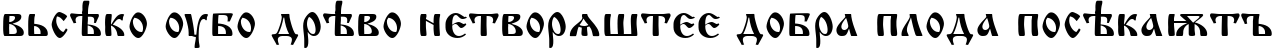

In [8]:
# https://lisovitskaya.com/2017/12/24/staroslavyanskij-glagol-v-tablicah/

TEXT = "вьсѣко ѹбо дрѣво нєтворѧштєє добра плода посѣкаѭтъ"

display_pillow_image(generate_text_as_image(TEXT, FONT_PATH, 50))

In [9]:
def symbol_borders(cuts):
    borders = []
    start, end = None, None
    
    for idx in range(1, len(cuts)):
        if start is None and cuts[idx - 1] == 0. and cuts[idx] > 0.:
            start = idx
        
        if end is None and cuts[idx - 1] > 0. and cuts[idx] == 0.:
            end = idx
            
        if start is not None and end is not None:
            borders.append((start, end))
            start, end = None, None
            
    return borders

In [10]:
def plot_text_with_borders(text):
    image = generate_text_as_image(text, FONT_PATH, 50)
    image = np.asarray(image)
    image = ~otsu_binarize(image)
    
    m, n = image.shape
    
    cuts = image.sum(0) / m
    
    borders = symbol_borders(cuts)

    _, axes = plt.subplots(2, 1, figsize=(20, 6))
    
    axes[0].imshow(image, cmap="binary")
    axes[0].axis("off")
    
    for pair in borders:
        axes[0].axvline(x=pair[0], c='red')
        axes[0].axvline(x=pair[1], c='red')

    axes[1].bar(np.arange(n), cuts, width=0.3)
    axes[1].set_xlim(0, n - 1)
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

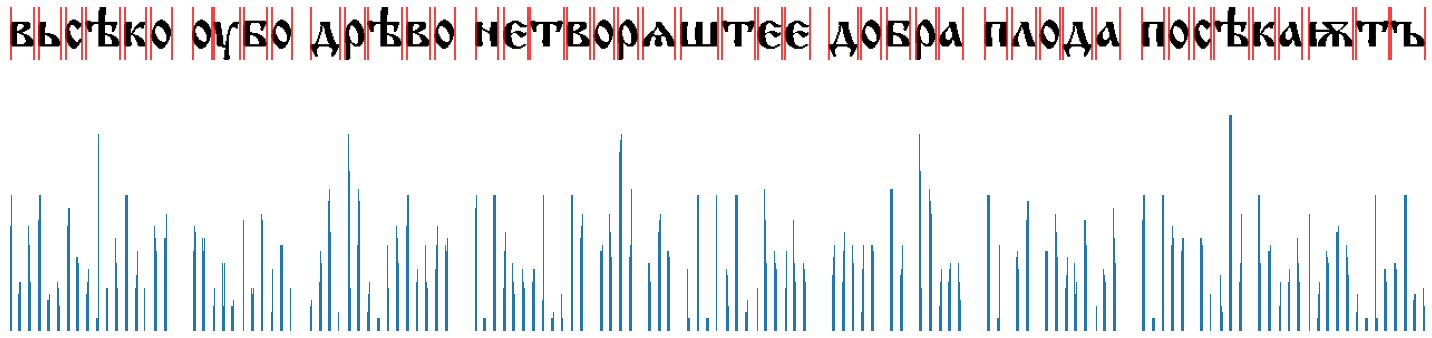

In [11]:
plot_text_with_borders(TEXT)